In [1]:
import cv2
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Helper function: image loading and visualisation.

In [2]:
def get_img(img):
    # Read img file; Convert BGR -> RGB; Standardise
    img = cv2.imread(img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255

def show_img(img):
    # Load to cpu, detach gradient, cast to ndarray and unstandardise
    img = img.to('cpu').detach().numpy() * 255
    img = img.astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)


In [3]:
class FungiDataset(Dataset):
    def __init__(self, fungi_root, transform=None, target_transform=None):
        fungi_list = [
            glob(f'{fungi_root}{h}/*') for h in [
                'H1', 'H2', 'H3', 'H5', 'H6'
            ]
        ]
        self.transform = transform
        self.target_transform = target_transform

        n = 700

        # TODO: random sample with seed
        print('\n'.join([f'Class {i}: {len(fungi_list[i])} samples' 
                             for i in range(len(fungi_list))]))
        fungi_list = [h[:n] for h in fungi_list]
        print('\n'.join([f'Class {i}: {len(fungi_list[i])} samples' 
                        for i in range(len(fungi_list))]))
        self.fungi = np.concatenate([
            np.array(h) for h in fungi_list
        ])

        self.labels = np.zeros(n*5)
        self.labels[n:n*2] = 1
        self.labels[n*2:n*3] = 2
        self.labels[n*3:n*4] = 3
        self.labels[n*4:] = 4

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = get_img(self.fungi[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return img, label

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv(in_channels=3, out_channels=8)
        self.conv2 = self.conv(in_channels=8, out_channels=16)
        self.conv3 = self.conv(in_channels=16, out_channels=32)
        self.conv4 = self.conv(in_channels=32, out_channels=64)
        self.conv5 = self.conv(in_channels=64, out_channels=128)
        self.conv6 = self.conv(in_channels=128, out_channels=128)
        self.conv7 = self.conv(in_channels=128, out_channels=128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3**2 * 128, 512)
        self.fc2 = nn.Linear(512, 5)
    
    def conv(self, in_channels, out_channels):
        return nn.Conv2d(in_channels=in_channels,
                                     out_channels= out_channels,
                                     kernel_size=3, 
                                     padding='same')
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [5]:
# RANDOM (WITH SEED) SAMPLING
# SEED EVERYTHING
# +sort glob

# deep model, ..., not enough data? -> augment albumentations
# first loss???

# train val test
# train loss val loss

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
fungids = FungiDataset(fungi_root='../data/defungi/', transform=transform)
dataloader = DataLoader(fungids, batch_size=4, shuffle=True)
print(f'Dataset size: {len(fungids)}')
print(f'Number of iterations per epoch: {len(dataloader)}')

Class 0: 4404 samples
Class 1: 2334 samples
Class 2: 819 samples
Class 3: 818 samples
Class 4: 739 samples
Class 0: 700 samples
Class 1: 700 samples
Class 2: 700 samples
Class 3: 700 samples
Class 4: 700 samples
Dataset size: 3500
Number of iterations per epoch: 875


Feature batch shape: torch.Size([4, 3, 500, 500])
Labels batch shape: torch.Size([4])
Feature shape: torch.Size([3, 500, 500])
Labels shape: torch.Size([])


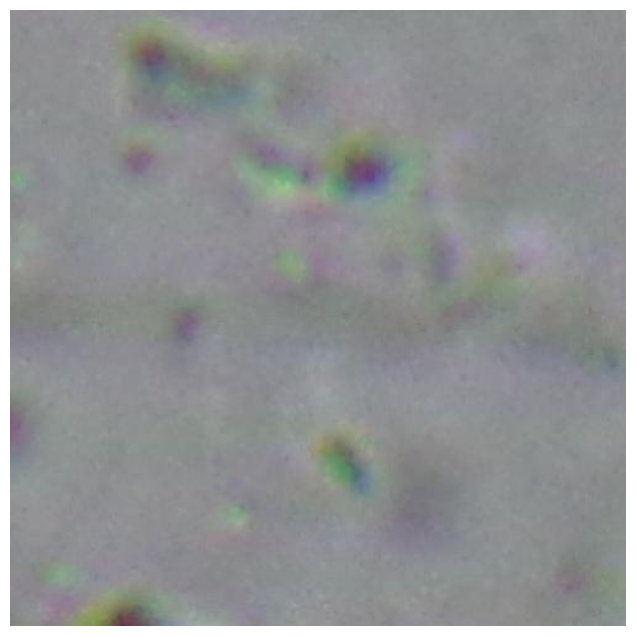

In [8]:
idx = 0
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[idx].squeeze()
label = train_labels[idx]
print(f"Feature shape: {img.size()}")
print(f"Labels shape: {label.size()}")

show_img(img)

In [9]:
cnn = ConvNet().to('cuda')

In [10]:
print(cnn)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [11]:
[param.nelement() for param in cnn.parameters()]

[216,
 8,
 1152,
 16,
 4608,
 32,
 18432,
 64,
 73728,
 128,
 147456,
 128,
 147456,
 128,
 589824,
 512,
 2560,
 5]

In [12]:
sum([param.nelement() for param in cnn.parameters()])

986453

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(), 
                                                lr=0.0001, 
                                                weight_decay=0,
                                                amsgrad=False)
# optimizer = torch.optim.AdamW(cnn.parameters(), 
#                                                     lr=0.001, 
#                                                     weight_decay=0.01, 
#                                                     amsgrad=False)

In [14]:
# links: data
# linke: pytorhc.org????
# references

# device if cuda availabe

In [15]:
EPOCHS = 2

In [16]:
for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader, 0):
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        optimizer.zero_grad()

        predictions = cnn(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # print every 100 mini-batches
        if not(i % 100) and i:
            print(f'EPOCH {epoch}: LOSS={running_loss/i}')

EPOCH 0: LOSS=1.6267937755584716
EPOCH 0: LOSS=1.6130260908603669
EPOCH 0: LOSS=1.5710326419274012
EPOCH 0: LOSS=1.5169509695470333
EPOCH 0: LOSS=1.4870620729923247
EPOCH 0: LOSS=1.4601589712500571
EPOCH 0: LOSS=1.4320776956421988
EPOCH 0: LOSS=1.417625812217593
EPOCH 1: LOSS=1.2055840927362442
EPOCH 1: LOSS=1.22742809638381
EPOCH 1: LOSS=1.2103913934032122
EPOCH 1: LOSS=1.1939722331613303
EPOCH 1: LOSS=1.1824238295555114
EPOCH 1: LOSS=1.164470759530862
EPOCH 1: LOSS=1.1573680381689753
EPOCH 1: LOSS=1.1485063331574201


In [17]:
            # print(f'EPOCH {epoch}: LOSS={running_loss/i}')

In [18]:
y_true = []#np.zeros(len(fungids))
y_pred = []#np.zeros(len(fungids))

# correct = 0
# total = 0

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        predictions = cnn(images)
        _, predictions = torch.max(predictions.data, 1)
        
        predictions = predictions.to('cpu').detach().numpy()
        labels = labels.to('cpu').detach().numpy()
        
        y_pred.extend(predictions)
        y_true.extend(labels)        

        # total += labels.size(0)
        # correct += (predictions == labels).sum().item()

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [21]:
pr = precision_score(y_true, y_pred, average='macro')
re = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

print(f'Precision: {pr}')
print(f'Recall: {re}')

Precision: 0.5573892946352139
Recall: 0.5765714285714285


In [22]:
np.unique(y_pred)

array([0, 1, 2, 3, 4])

In [23]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

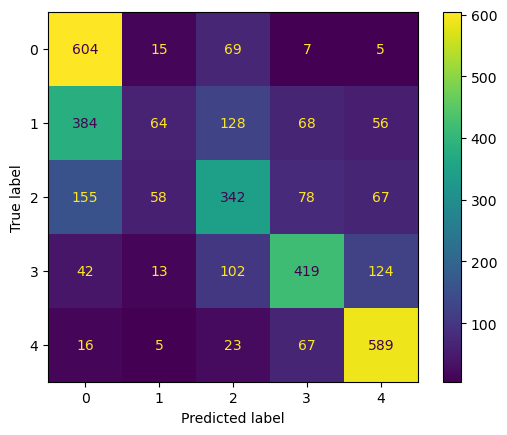

In [24]:
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

In [25]:
crep = classification_report(y_true=y_true, y_pred=y_pred)

In [26]:
print(crep)

              precision    recall  f1-score   support

           0       0.50      0.86      0.64       700
           1       0.41      0.09      0.15       700
           2       0.52      0.49      0.50       700
           3       0.66      0.60      0.63       700
           4       0.70      0.84      0.76       700

    accuracy                           0.58      3500
   macro avg       0.56      0.58      0.54      3500
weighted avg       0.56      0.58      0.54      3500



In [56]:
np.unique(y_true)

array([0, 1, 2, 3, 4])

In [25]:
correct / total

0.2

[4, 4, 4, 4]

In [3]:
images, labels = next(iter(dataloader))
images = images.to('cuda', dtype=torch.float)
labels = labels.to('cuda', dtype=torch.int64)

NameError: name 'dataloader' is not defined

In [2]:
5956+48000

53956

In [26]:
fake_imgfile_list = glob('../data/CIFAKE/train/FAKE/*')
real_imgfile_list = glob('../data/CIFAKE/train/REAL/*')

In [41]:
img = cv2.imread(real_imgfile_list[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB

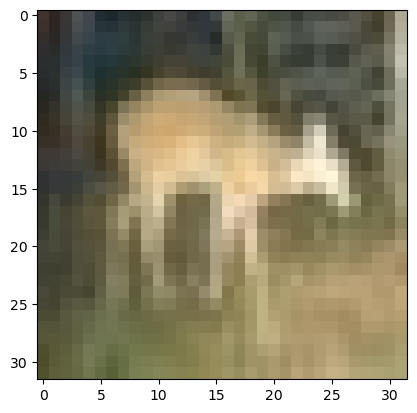

In [42]:
plt.imshow(img)
plt.show()

In [46]:
real = [cv2.imread(imgfile) for imgfile in real_imgfile_list]
fake = [cv2.imread(imgfile) for imgfile in fake_imgfile_list]

In [47]:
# np.float16
real = np.array(real)
fake = np.array(fake)


In [48]:
real.shape

(50000, 32, 32, 3)

In [49]:
fake.shape

(50000, 32, 32, 3)

In [51]:
fake.dtype

dtype('uint8')

In [52]:
real.mean(), real.min(), real.max()

(120.68823526692708, 0, 255)

In [54]:
real = real / 255
fake = fake / 255

In [55]:
real.mean(), real.min(), real.max()

(0.4732871971252034, 0.0, 1.0)

In [15]:
fungi = [
    glob(f'../data/defungi/{h}/*') for h in [
        'H1', 'H2', 'H3', 'H5', 'H6'
    ]
]

In [16]:
[len(h) for h in fungi]

[4404, 2334, 819, 818, 739]

In [17]:
fungi = [
    np.array([cv2.imread(imgfile) for imgfile in h])
    for h in fungi
]

In [18]:
[h.shape for h in fungi]

[(4404, 500, 500, 3),
 (2334, 500, 500, 3),
 (819, 500, 500, 3),
 (818, 500, 500, 3),
 (739, 500, 500, 3)]

In [19]:
fungi = [
    h[:500, :]
    for h in fungi
]

Could use albumentations to augment underrepresented classes, oversampling etc., but use undersampling (correct?) since this already takes 6.5GB as it is...

In [ ]:
fungi = [
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
]

In [20]:
4404 + 2334 + 819 + 818 + 739

9114

In [21]:
fungi = np.concatenate(fungi)

In [22]:
fungi.shape

(2500, 500, 500, 3)

In [12]:
fungi.shape

(9114, 500, 500, 3)

In [13]:
9114 * 500 * 500 * 3 / 1024**2

6518.840789794922

In [23]:
2500 * 500 * 500 * 3 / 1024**2

1788.1393432617188

In [26]:
fungi_labels = np.zeros(2500)
fungi_labels[500:1000] = 1
fungi_labels[1000:1500] = 2
fungi_labels[1500:2000] = 3
fungi_labels[2000:] = 4

In [27]:
fungi_labels.shape

(2500,)

In [ ]:
cv2.cvt_color

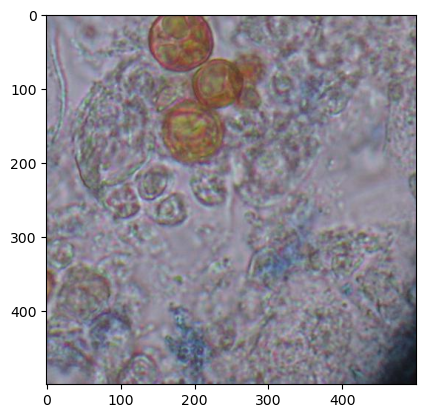

In [41]:
plt.imshow(fungi[1780])